# Chapter 6 Reinforcement Learning

In [5]:
%matplotlib inline

In [6]:
from collections import namedtuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mdptoolbox

np.random.seed(0)

### Time value of money

In [3]:
discount = 0.05
payment = 1
horizon = 1000000

sum([
    (1 + discount) ** -i
    for i in range(1, horizon + 1)
]) * payment

19.999999999999943

In [4]:
# infinite annuity
payment / discount

20.0

In [5]:
# finite annuity
payment * ((1 - (1 + discount) ** -horizon) / discount)

20.0

## Multi-armed bandits

In [6]:
Arm = namedtuple('Arm', ['mu', 'std'])

arms = [Arm(mu=10, std=2), Arm(mu=12, std=5)]

In [7]:
def get_rewards(arms, n):
    return np.clip(np.array([
        np.random.normal(loc=arm.mu, scale=arm.std, size=n)
        for arm in arms
    ]), 0, 100)

In [9]:
rewards = get_rewards(arms, 1000)

In [42]:
rewards.shape

(2, 1000)

In [10]:
# first sample from each machine
rewards[:, 0]

array([13.52810469, 14.7798134 ])

In [11]:
# first sample from each machine
rewards[:, 1]

array([10.80031442, 16.46236944])

In [43]:
# 3rd sample from each machine
rewards[:, 2]

array([11.95747597,  9.88842588])

In [13]:
# 4th sample from each machine
rewards[:, 3]

array([14.4817864 , 12.52357015])

In [44]:
# cumulative rewards for the first 4 sample
cumsum = np.cumsum(rewards[:, :4], axis=1)
cumsum

array([[13.52810469, 24.32841911, 36.28589508, 50.76768148],
       [14.7798134 , 31.24218284, 41.13060871, 53.65417886]])

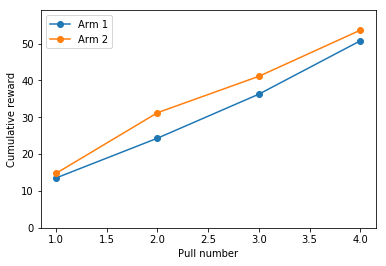

In [53]:
df = pd.DataFrame({
    'Arm 1': cumsum[0, :],
    'Arm 2': cumsum[1, :]
})
df.index += 1
df.plot(marker='o')
plt.ylim([0, np.max(cumsum) * 1.1])
plt.xlabel('Pull number')
_ = plt.ylabel('Cumulative reward')
plt.

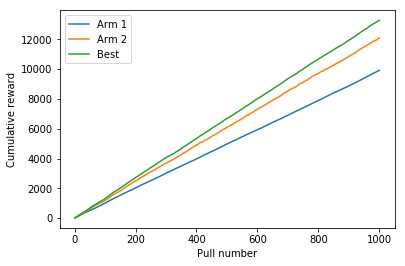

In [55]:
df = pd.DataFrame({
    'Arm 1': np.cumsum(rewards[0, :]),
    'Arm 2': np.cumsum(rewards[1, :]),
    'Best': np.cumsum(np.max(rewards, axis=0))
})
df.index += 1
df.plot()
plt.xlabel('Pull number')
_ = plt.ylabel('Cumulative reward')

### Random strategy

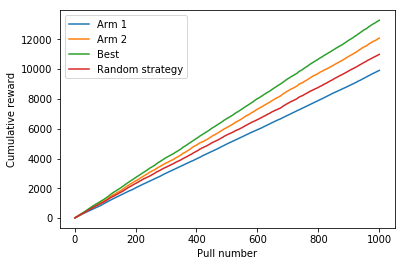

In [97]:
# randomly select row 0 or 1 (arm 1 or 2)
# for all 1,000 examples
random_row = np.random.randint(0, 2, 1000)
rewards_random = rewards[random_row, np.arange(rewards.shape[1])]

df = pd.DataFrame({
    'Arm 1': np.cumsum(rewards[0, :]),
    'Arm 2': np.cumsum(rewards[1, :]),
    'Best': np.cumsum(np.max(rewards, axis=0)),
    'Random strategy': np.cumsum(rewards_random)
})
df.index += 1
df.plot()
plt.xlabel('Pull number')
_ = plt.ylabel('Cumulative reward')

In [37]:
# mean reward for machine/arm 1
np.mean(rewards[0, :])

9.909486585019609

In [38]:
# mean reward for machine/arm 2
np.mean(rewards[1, :])

12.076522363745909

In [255]:
class Strategy:
    def __init__(self, rewards):
        self.rewards = rewards
        # number of arms
        self.arms = rewards.shape[0]
        self.pulls = rewards.shape[1]
        # initialize the cumulative reward
        # for each arm
        self.vals = [0] * self.arms
        self.counts = [0] * self.arms
        # used for keeping tracking of
        # reward indices for arms
        self.indices = [0] * self.arms
        self.selections = []
        self.rewards_total = 0
        self.reward_by_step = []
        # random strategy for comparison
        random_row = np.random.randint(0, self.arms, self.pulls)
        rewards_random = rewards[random_row, np.arange(self.pulls)]
        self.random_strategy = np.cumsum(rewards_random)

        
class EpsilonGreedy(Strategy):
    def __init__(self, rewards, epsilon, init_vals=0):
        super().__init__(rewards)
        self.epsilon = epsilon
        self.vals = [init_vals] * self.arms
        self.title = 'Epsilon greedy with eps'
        
    def _pick_arm(self, _):
        explore = np.random.rand() <= self.epsilon
        if explore:
            # randomly pick an arm index
            return np.random.choice(range(self.arms))
        else:
            return np.argmax(self.vals)
        
    def _calc_val(self, arm, reward_new):
        count = self.counts[arm]
        val = self.vals[arm]
        return (count * val + reward_new) / (count + 1)
    
    def pull_n_times(self, n, verbose=True):
        assert n <= self.pulls, "Select n <= {}".format(self.pulls)
        
        for t in range(n):
            arm = self._pick_arm(t)
            self.selections.append(arm)
            arm_index = self.indices[arm]
            reward = self.rewards[arm, arm_index]
            self.indices[arm] += 1
            self.vals[arm] = self._calc_val(arm, reward)
            self.counts[arm] += 1
            self.rewards_total += reward
            self.reward_by_step.append(reward)
            
        best_arm = np.argmax(np.sum(self.rewards, axis=1))
        best_arm_reward = np.sum(self.rewards[best_arm, :n])
        regret = best_arm_reward - self.rewards_total
        
        if verbose:
            print('Cumulative reward : {:.1f}'.format(self.rewards_total))
            print('Best arm reward   : {:.1f}'.format(best_arm_reward))
            print('Regret            : {:.1f}'.format(regret))
            title = '{}={}'.format(self.title, self.epsilon)

            df = pd.DataFrame({
                title: np.cumsum(self.reward_by_step),
                'Best arm (arm index {})'.format(best_arm): np.cumsum(self.rewards[best_arm, :n]),
                'Random strategy': self.random_strategy
                
            })
            df.index += 1
            df.plot()
            plt.xlabel('Pull number')
            plt.ylabel('Cumulative reward')
        
        return self.rewards_total, best_arm_reward, regret

### Epsilon-greedy

Cumulative reward : 11984.8
Best arm reward   : 12076.5
Regret            : 91.8


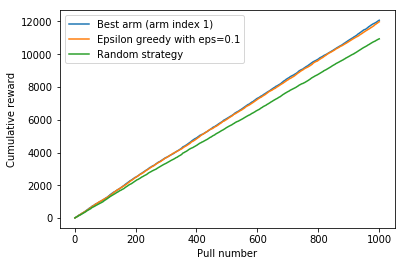

In [256]:
eps = EpsilonGreedy(rewards, 0.1)
_ = eps.pull_n_times(1000)

Cumulative reward : 11008.9
Best arm reward   : 12076.5
Regret            : 1067.6


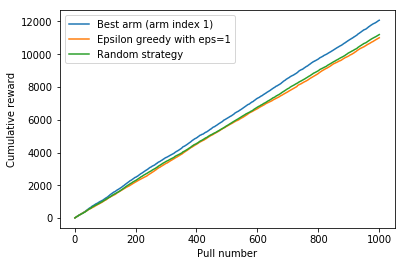

In [258]:
eps = EpsilonGreedy(rewards, 1)
_ = eps.pull_n_times(1000)

Cumulative reward : 9909.5
Best arm reward   : 12076.5
Regret            : 2167.0


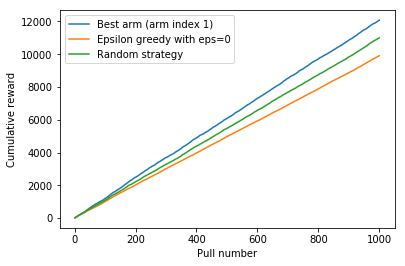

In [259]:
eps = EpsilonGreedy(rewards, 0)
_ = eps.pull_n_times(1000)

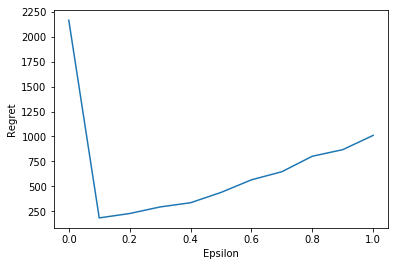

In [260]:
pd.Series({
    epsilon: EpsilonGreedy(rewards, epsilon).pull_n_times(1000, verbose=False)[2]
    for epsilon in np.arange(0, 1 + 0.1, 0.1)
}).plot()
plt.xlabel('Epsilon')
plt.ylabel('Regret')
plt.show()

### Optimistic Initial Values

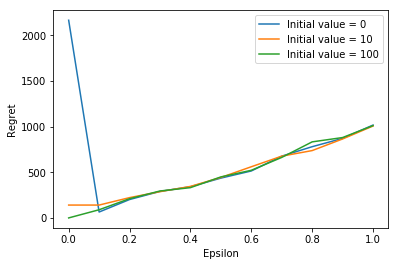

In [261]:
for init_val in [0, 10, 100]:
    pd.Series({
        epsilon: EpsilonGreedy(rewards, epsilon, init_vals=init_val).pull_n_times(1000, verbose=False)[2]
        for epsilon in np.arange(0, 1 + 0.1, 0.1)
    }).plot(label='Initial value = {}'.format(init_val))
    plt.xlabel('Epsilon')
    plt.ylabel('Regret')
plt.legend()
plt.show()

### Upper Confidence Bound (UCB)

In [264]:
class UCB(EpsilonGreedy):
    def __init__(self, rewards, c):
        super().__init__(rewards, epsilon=0, init_vals=0)
        self.c = c
        self.epsilon = c
        self.title = 'UCB with c'
        
    def _pick_arm(self, t):
        # if all of the arms have been pulled at least once
        if np.count_nonzero(self.counts) == len(self.counts):
            augmented = self.vals + self.c * np.sqrt(np.log(t) / self.counts)
            return np.argmax(augmented)
        else:
            return np.argmax(np.array(self.counts) == 0)

Cumulative reward : 12074.2
Best arm reward   : 12076.5
Regret            : 2.3


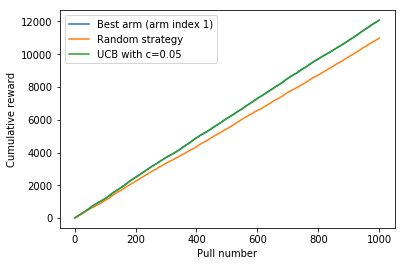

In [265]:
ucb = UCB(rewards, c=0.05)
_ = ucb.pull_n_times(1000)

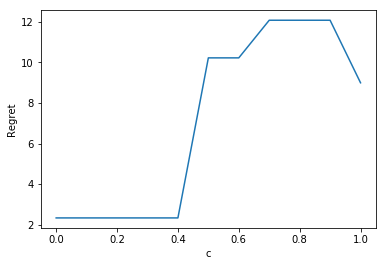

In [302]:
pd.Series({
    c: UCB(rewards, c).pull_n_times(1000, verbose=False)[2]
    for c in np.arange(0, 1 + 0.1, 0.1)
}).plot()
plt.xlabel('c')
plt.ylabel('Regret')
plt.show()

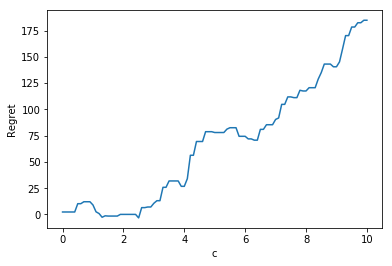

In [303]:
pd.Series({
    c: UCB(rewards, c).pull_n_times(1000, verbose=False)[2]
    for c in np.arange(0, 10 + 0.1, 0.1)
}).plot()
plt.xlabel('c')
plt.ylabel('Regret')
plt.show()

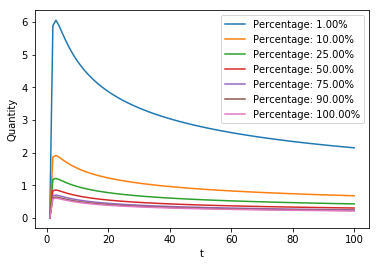

In [268]:
ts = range(1, 100 + 1)

df = pd.DataFrame({'t': ts})
for pct in [.01, 0.1, 0.25, .5, .75, 0.9, 1]:
    vals = [np.sqrt(np.log(t) / (pct * t)) for t in ts]
    df['Percentage: {:.2f}%'.format(pct * 100)] = vals
    
df.set_index('t').plot()
_ = plt.ylabel('Quantity')

### N armed-bandit

In [304]:
N = 10

std = 1
arms = [Arm(10 + i, std) for i in range(N)]
pulls = 1000
c = 0.1

Cumulative reward : 18926.5
Best arm reward   : 18975.8
Regret            : 49.3


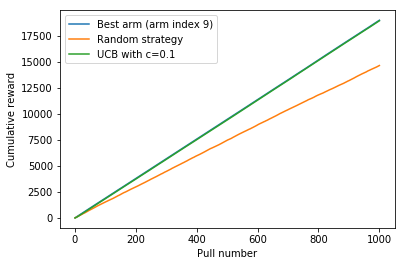

In [305]:
ucb = UCB(get_rewards(arms, pulls), c)
_ = ucb.pull_n_times(pulls)

## MDP

In [ ]:
# !pip install pymdptoolboox

### Grid World

In [2]:
actions = 4
rows = 3
cols = 3
states = rows * cols

class Action:
    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 3

# lookup table for special states
special = {
    (0, 1): 'wall',
    (0, 2): 'prize',
    (2, 1): 'death',
    (2, 2): 'wall'
}

```
+---+---+---+
|   |███| 🎁|
+---+---+---+
|   |   |   |
+---+---+---+
|   | ☠|███|
+---+---+---+

Actions:
0 Up
1 Right
2 Down
3 Left
```

In [7]:
def get_T_and_R(actions,
               states,
               p_slip,
               reward_good,
               reward_bad):
    T = np.zeros((actions, states, states))
    R = np.zeros((actions, states, states))
    assert 0 <= p_slip <= 0.5

    T[0, 0, 0] = 1.0
    T[1, 0, 0] = 1.0 - p_slip
    T[1, 0, 3] = p_slip
    T[2, 0, 0] = p_slip * 2
    T[2, 0, 3] = 1.0 - 2 * p_slip
    T[3, 0, 0] = 1.0 - p_slip
    T[3, 0, 3] = p_slip

    # State 1
    T[:, 1, 1] = 1

    # State 2
    T[:, 2, 2] = 1

    # State 3
    T[0, 3, 0] = 1.0 - 2 * p_slip
    T[0, 3, 3] = p_slip
    T[0, 3, 4] = p_slip
    T[1, 3, 0] = p_slip
    T[1, 3, 4] = 1.0 - 2 * p_slip
    T[1, 3, 6] = p_slip
    T[2, 3, 3] = p_slip
    T[2, 3, 4] = p_slip
    T[2, 3, 6] = 1.0 - 2 * p_slip
    T[3, 3, 3] = 1.0 - 2 * p_slip
    T[3, 3, 0] = p_slip
    T[3, 3, 6] = p_slip

    # State 4
    T[0, 4, 4] = 1.0 - 2 * p_slip
    T[0, 4, 3] = p_slip
    T[0, 4, 5] = p_slip
    T[1, 4, 4] = p_slip
    T[1, 4, 7] = p_slip
    T[1, 4, 5] = 1.0 - 2 * p_slip
    T[2, 4, 3] = p_slip
    T[2, 4, 5] = p_slip
    T[2, 4, 7] = 1.0 - 2 * p_slip
    T[3, 4, 4] = p_slip
    T[3, 4, 3] = 1.0 - 2 * p_slip
    T[3, 4, 7] = p_slip

    # State 5
    T[0, 5, 5] = p_slip
    T[0, 5, 2] = 1.0 - 2 * p_slip
    T[0, 5, 4] = p_slip
    T[1, 5, 5] = 1.0 - p_slip
    T[1, 5, 2] = p_slip
    T[2, 5, 5] = 1.0 - p_slip
    T[2, 5, 4] = p_slip
    T[3, 5, 5] = p_slip
    T[3, 5, 4] = 1.0 - 2 * p_slip
    T[3, 5, 2] = p_slip

    # State 6
    T[0, 6, 6] = p_slip
    T[0, 6, 3] = 1.0 - 2 * p_slip
    T[0, 6, 7] = p_slip
    T[1, 6, 6] = p_slip
    T[1, 6, 3] = p_slip
    T[1, 6, 7] = 1.0 - 2 * p_slip
    T[2, 6, 6] = 1.0 - p_slip
    T[2, 6, 7] = p_slip
    T[3, 6, 6] = 1.0 - p_slip
    T[3, 6, 3] = p_slip

    # State 7
    T[:, 7, 7] = 1

    # State 8
    T[:, 8, 8] = 1

    assert np.all([
        T[a, s, :].sum() == 1
        for a in range(actions)
        for s in range(states)
    ])

    R[:, 4, 7] = reward_bad
    R[0, 4, 7] = 0

    R[:, 6, 7] = reward_bad
    R[3, 6, 7] = 0

    R[:, 5, 2] = reward_good
    R[2, 5, 2] = 0
    
    return T, R

def create_row(vals, row_index):
    out = ''
    lookup = {0: ' ↑ ',
              1: ' → ',
              2: ' ↓ ',
              3: ' ←',
              'wall':  '███',
              'prize': ' 🎁',
              'death': ' ☠'
             }
    border = '+---' * len(vals) + '+'
    
    if row_index == 0:
        out += '{}\n'.format(border)
    
    for i, val in enumerate(vals):
        coord = (row_index, i)
        val = special[coord] if coord in special else val
        out += '|{}'.format(lookup[val])
        
    out += '+\n'
    out += border
        
    return out

def show_world(policy):
    for i in range(policy.shape[0]):
        print(create_row(policy[i, :], i))
        
def run_value_iteration(T, R, discount, rows, cols):
    vi = mdptoolbox.mdp.ValueIteration(T, R, discount=discount)

    vi.setSilent()
    vi.run()

    policy = np.array(vi.policy).reshape((rows, cols))
    V = np.array(vi.V).reshape((rows, cols))

    show_world(policy)
    print()
    print(V)

In [16]:
T, R = get_T_and_R(actions, states,
                   p_slip=0,
                   reward_good=+1,
                   reward_bad=-1)
T.shape

(4, 9, 9)

In [17]:
type(T)

numpy.ndarray

In [20]:
T[1, 0, 8]

0.0

In [26]:
T, R = get_T_and_R(actions, states,
                   p_slip=0.1,
                   reward_good=+1,
                   reward_bad=-1)
T[1, 3, :]

array([0.1, 0. , 0. , 0. , 0.8, 0. , 0.1, 0. , 0. ])

### Value Iteration

In [5]:
T, R = get_T_and_R(actions, states,
                   p_slip=0,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.999, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.997003 0.       0.      ]
 [0.998001 0.999    1.      ]
 [0.997003 0.       0.      ]]


In [27]:
T, R = get_T_and_R(actions, states,
                   p_slip=0,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.9, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.729 0.    0.   ]
 [0.81  0.9   1.   ]
 [0.729 0.    0.   ]]


In [34]:
T, R = get_T_and_R(actions, states,
                   p_slip=0,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.1, rows=rows, cols=cols)

+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.  0.  0. ]
 [0.  0.1 1. ]
 [0.  0.  0. ]]


In [8]:
T, R = get_T_and_R(actions, states,
                   p_slip=0,
                   reward_good=+1000,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.1, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[   1.    0.    0.]
 [  10.  100. 1000.]
 [   1.    0.    0.]]


In [9]:
T, R = get_T_and_R(actions, states,
                   p_slip=0.1,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.9, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.46194508 0.         0.        ]
 [0.5265261  0.63539471 0.94196104]
 [0.30645225 0.         0.        ]]


In [10]:
T, R = get_T_and_R(actions, states,
                   p_slip=0.2,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.9, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+

[[0.28074043 0.         0.        ]
 [0.33387994 0.45515808 0.83148967]
 [0.21176434 0.         0.        ]]


In [11]:
T, R = get_T_and_R(actions, states,
                   p_slip=0.05,
                   reward_good=+1,
                   reward_bad=-100)
run_value_iteration(T, R, discount=0.9, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+

[[0.21017488 0.         0.        ]
 [0.2371802  0.2784303  0.95548373]
 [0.06690418 0.         0.        ]]


In [12]:
T, R = get_T_and_R(actions, states,
                   p_slip=0,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.9, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.729 0.    0.   ]
 [0.81  0.9   1.   ]
 [0.729 0.    0.   ]]


#### Add slippage

In [28]:
T, R = get_T_and_R(actions, states,
                   p_slip=0.1,
                   reward_good=+1,
                   reward_bad=-1)
run_value_iteration(T, R, discount=0.9, rows=rows, cols=cols)

+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.46194508 0.         0.        ]
 [0.5265261  0.63539471 0.94196104]
 [0.30645225 0.         0.        ]]


In [33]:
T[3, 6, :]

array([0. , 0. , 0. , 0.1, 0. , 0. , 0.9, 0. , 0. ])

### Breakdown by iteration

In [40]:
T, R = get_T_and_R(actions, states,
                   p_slip=0.1,
                   reward_good=+1,
                   reward_bad=-1)

In [41]:
def by_iteration(epsilon):
    vi = mdptoolbox.mdp.ValueIteration(T, R, discount=0.9, epsilon=epsilon)

    #run value iteration silently
    vi.setVerbose()
    vi.run()

    #print policy found by value iteration
    policy = np.array(vi.policy).reshape((rows, cols))
    V = np.array(vi.V).reshape((rows, cols))

    show_world(policy)
    print()
    print(V)

In [42]:
by_iteration(10)

  Iteration		V-variation
    1		  0.8
Iterating stopped, epsilon-optimal policy found.
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+

[[0.  0.  0. ]
 [0.  0.  0.8]
 [0.  0.  0. ]]


In [43]:
by_iteration(5)

  Iteration		V-variation
    1		  0.8
    2		  0.4760000000000002
Iterating stopped, epsilon-optimal policy found.
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+

[[0.    0.    0.   ]
 [0.    0.476 0.872]
 [0.    0.    0.   ]]


In [44]:
.8 + .1 * .9 * .8 + .1 * 0

0.8720000000000001

In [45]:
by_iteration(4)

  Iteration		V-variation
    1		  0.8
    2		  0.4760000000000002
    3		  0.3427200000000002
Iterating stopped, epsilon-optimal policy found.
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+

[[0.      0.      0.     ]
 [0.34272 0.57068 0.92132]
 [0.      0.      0.     ]]


In [46]:
by_iteration(3)

  Iteration		V-variation
    1		  0.8
    2		  0.4760000000000002
    3		  0.3427200000000002
    4		  0.24675840000000013
Iterating stopped, epsilon-optimal policy found.
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.2467584 0.        0.       ]
 [0.4108896 0.6147116 0.93428  ]
 [0.1467584 0.        0.       ]]


In [47]:
by_iteration(1)

  Iteration		V-variation
    1		  0.8
    2		  0.4760000000000002
    3		  0.3427200000000002
    4		  0.24675840000000013
    5		  0.09349862399999995
Iterating stopped, epsilon-optimal policy found.
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.34025702 0.         0.        ]
 [0.47800886 0.62800564 0.93940924]
 [0.20904877 0.         0.        ]]


In [48]:
by_iteration(1e-2)

  Iteration		V-variation
    1		  0.8
    2		  0.4760000000000002
    3		  0.3427200000000002
    4		  0.24675840000000013
    5		  0.09349862399999995
    6		  0.06515562240000011
    7		  0.028714771123200034
    8		  0.015420263922431954
    9		  0.006898644520865305
    10		  0.0033288479109944147
    11		  0.0014859837664340514
    12		  0.0006839220939536816
Iterating stopped, epsilon-optimal policy found.
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[0.46194508 0.         0.        ]
 [0.5265261  0.63539471 0.94196104]
 [0.30645225 0.         0.        ]]


### Policy iteration

In [25]:
pi = mdptoolbox.mdp.PolicyIteration(T, R, discount=0.9)

#run value iteration silently
pi.setVerbose()
pi.run()

#print policy found by value iteration
policy = np.array(pi.policy).reshape((rows, cols))
V = np.array(pi.V).reshape((rows, cols))

show_world(policy)
print()
print(V)

  Iteration		Number of different actions
    1		  3
    2		  1
    3		  0
Iterating stopped, unchanging policy found.
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+

[[4.62494056e-01 0.00000000e+00 4.69743229e-17]
 [5.26729341e-01 6.35398926e-01 9.41962531e-01]
 [3.06862776e-01 0.00000000e+00 0.00000000e+00]]


### Q-Learning

In [532]:
class QLearner:
    def __init__(self, epsilon, alpha, gamma,
                 start_state=6, finish_states={2, 7}, walls={1, 8}):
        assert start_state not in finish_states.union(walls)
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.start_state = 6
        self.finish_states = finish_states
        self.state = start_state
        self.actions = T.shape[0]
        self.states = T.shape[1]
        self.q = np.zeros((self.states, self.actions))
        
    def _reset(self):
        self.state = self.start_state
    
    def _act(self, action):
        if action in range(self.actions):
            probs = T[action, self.state, :]
            s_prime = np.random.choice(range(self.states), p=probs)
            finished = False
            reward = R[action, self.state, s_prime]
            if s_prime in self.finish_states:
                finished = True
                self._reset()
            else:
                self.state = s_prime
            return s_prime, reward, finished
        else:
            raise ValueError("Action {} is not supported".format(action))
    
    def _q_update(self, s, a, r, s_prime):
        q = self.q[s, a]
        later_reward = self.q[s_prime, np.argmax(self.q[s_prime, :])]
        improved_estimate = r + self.gamma * later_reward
        self.q[s, a] = (1 - self.alpha) * q + self.alpha * improved_estimate
        
    def _update(self):
        explore = np.random.rand() <= self.epsilon
        action = (np.random.randint(self.actions) if explore
                  else np.argmax(self.q[self.state, :]))
        s = self.state
        s_prime, reward, finished = self._act(action)
        self._q_update(s, action, reward, s_prime)
        return reward, finished, s_prime, action, explore
        
    def learn(self, episodes, verbose=False, show_every=1000, print_every=100):
        for episode in range(episodes):
            finished = False
            i = 0
            while not finished:
                reward, finished, _, _, _ = self._update()
                i += 1
                
            if verbose:
                if episode == 0 or (episode + 1) % print_every == 0:
                    out = 'Finished epsiode {} after {} steps with reward {}'
                    print(out.format(episode, i, reward))
                
                if episode == 0 or (episode + 1) % show_every == 0:
                    show_world(np.argmax(q.q, axis=1).reshape((rows, cols)))

In [533]:
q = QLearner(epsilon=0.1, alpha=0.1, gamma=0.9)

In [241]:
q._act(Action.UP)

(3, 0.0, False)

In [242]:
q._act(Action.RIGHT)

(4, 0.0, False)

In [243]:
q._act(Action.RIGHT)

(5, 0.0, False)

In [244]:
q._act(Action.UP)

(2, 1.0, True)

In [245]:
q._reset()

In [539]:
q = QLearner(epsilon=0.1, alpha=0.1, gamma=0.9)
q.learn(50000, verbose=True, show_every=5000, print_every=2500)

Finished epsiode 0 after 1274 steps with reward 1.0
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | ↑ | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 2499 after 5 steps with reward 1.0
Finished epsiode 4999 after 7 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 7499 after 15 steps with reward 1.0
Finished epsiode 9999 after 6 steps with reward -1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 12499 after 1 steps with reward -1.0
Finished epsiode 14999 after 14 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 17499 after 4 steps with reward 1.0
Finished epsiode 19999 after 23 steps with reward -1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 22499 after 17 steps with r

In [540]:
q = QLearner(epsilon=0.1, alpha=0.5, gamma=0.9)
q.learn(50000, verbose=True, show_every=5000, print_every=2500)

Finished epsiode 0 after 516 steps with reward 1.0
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | ↑ | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 2499 after 18 steps with reward 1.0
Finished epsiode 4999 after 4 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 7499 after 5 steps with reward 1.0
Finished epsiode 9999 after 68 steps with reward -1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| ←| → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 12499 after 17 steps with reward 1.0
Finished epsiode 14999 after 15 steps with reward -1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 17499 after 9 steps with reward 1.0
Finished epsiode 19999 after 16 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 22499 after 27 steps with rew

In [541]:
q = QLearner(epsilon=0.01, alpha=0.1, gamma=0.9)
q.learn(50000, verbose=True, show_every=5000, print_every=2500)

Finished epsiode 0 after 2040 steps with reward 1.0
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | ↑ | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 2499 after 15 steps with reward 1.0
Finished epsiode 4999 after 16 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 7499 after 5 steps with reward 1.0
Finished epsiode 9999 after 17 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 12499 after 27 steps with reward -1.0
Finished epsiode 14999 after 20 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | ↑ | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 17499 after 24 steps with reward 1.0
Finished epsiode 19999 after 11 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 22499 after 37 steps with r

In [542]:
q = QLearner(epsilon=0.1, alpha=0.01, gamma=0.9)
q.learn(50000, verbose=True, show_every=5000, print_every=2500)

Finished epsiode 0 after 833 steps with reward 1.0
+---+---+---+
| ↑ |███| 🎁+
+---+---+---+
| ↑ | ↑ | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 2499 after 4 steps with reward 1.0
Finished epsiode 4999 after 4 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 7499 after 5 steps with reward -1.0
Finished epsiode 9999 after 15 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ←| ☠|███+
+---+---+---+
Finished epsiode 12499 after 7 steps with reward 1.0
Finished epsiode 14999 after 4 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 17499 after 1 steps with reward -1.0
Finished epsiode 19999 after 5 steps with reward 1.0
+---+---+---+
| ↓ |███| 🎁+
+---+---+---+
| → | → | ↑ +
+---+---+---+
| ↑ | ☠|███+
+---+---+---+
Finished epsiode 22499 after 4 steps with rewar

In [ ]:
# decay alpha, otherwise no good`

## Deep Q-Learning

In [170]:
# install box2d by following:
# https://github.com/pybox2d/pybox2d/blob/master/INSTALL.md
# then
# pip install gym

> Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

In [49]:
import gym

In [50]:
env = gym.make('LunarLander-v2')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [51]:
print(env.action_space)

Discrete(4)


In [52]:
print(env.observation_space)

Box(8,)


In [61]:
state = env.reset()
state

array([ 0.00415268,  0.93623248,  0.42060881, -0.29206429, -0.00480515,
       -0.09527405,  0.        ,  0.        ])

In [62]:
action = 0
state_next, reward, done, _ = env.step(action)
print('reward     : {}'.format(reward))
print('next state : {}'.format(state_next))
print('done       : {}'.format(done))

reward     : -1.4567268781058829
next state : [ 0.00830536  0.93146716  0.42004108 -0.31771205 -0.00951314 -0.09416826
  0.          0.        ]
done       : False


In [63]:
state_next

array([ 0.00830536,  0.93146716,  0.42004108, -0.31771205, -0.00951314,
       -0.09416826,  0.        ,  0.        ])

In [64]:
reward

-1.4567268781058829

In [23]:
done

False

In [65]:
env.close()

In [66]:
# number of states if discretized to [0.1, ..., 1]
10 ** 6 * 2 * 2

4000000

### Random agent

In [73]:
env = gym.make('LunarLander-v2')
actions = env.action_space.n
episodes = 1000

results = []

for episode_index in range(episodes):
    state = env.reset()
    done = False
    rewards = 0
    rewards_cumulative = []

    while not done:
        action = env.action_space.sample()
        s_prime, reward, done, _ = env.step(action)
        state = s_prime
        rewards += reward
        rewards_cumulative.append(rewards)
        
    results.append(rewards_cumulative)
        
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [81]:
c = pd.Series([len(x) for x in results])
c.describe()

count    1000.000000
mean       93.222000
std        35.003657
min        52.000000
25%        76.000000
50%        91.000000
75%       106.000000
max      1000.000000
dtype: float64

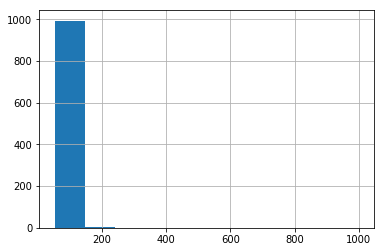

In [83]:
_ = c.hist()

In [79]:
r = pd.Series([x[-1] for x in results])
r.describe()

count    1000.000000
mean     -226.104549
std       105.824792
min      -658.181985
25%      -287.486231
50%      -194.511855
75%      -150.165514
max        61.812355
dtype: float64

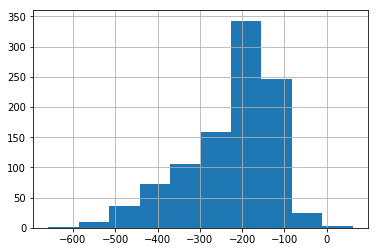

In [84]:
_ = r.hist()

### Deep Q

In [165]:
from collections import defaultdict, deque
import datetime
from functools import partial
import random
from gym.wrappers import Monitor

from keras import backend
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

In [136]:
class Uniform:
    def __init__(self, buffer_size, buffer_items, seed=0):
        np.random.seed(seed)
        random.seed(seed)

        # https://github.com/amirziai/learning/blob/master/python/defaultdict-of-fixed-length-buffers.ipynb
        self.buffer = defaultdict(partial(deque, maxlen=buffer_size))
        self.buffer_items = buffer_items

    def add(self, kwargs, priority):
        for item in self.buffer_items:
            self.buffer[item].append(kwargs[item])

    def _sample_index(self, random_indices):
        return {item: np.array([self.buffer[item][i] for i in random_indices])
                for item in self.buffer_items}

    def sample(self, number_samples):
        buffer_length = len(self)
        n = min(number_samples, buffer_length)
        random_indices = random.sample(range(buffer_length), n)
        return self._sample_index(random_indices)

    def __len__(self):
        try:
            return len(next(iter(self.buffer.values())))
        except StopIteration:
            return 0


class Prioritized(Uniform):
    def __init__(self, buffer_size, buffer_items, seed=0):
        super().__init__(buffer_size, buffer_items, seed)
        self.priority = deque(maxlen=buffer_size)

    def add(self, kwargs, priority):
        super().add(kwargs, priority)
        self.priority.append(priority)

    def sample(self, number_samples):
        """
        Samples given the normalized priority of items
         
        :param number_samples: number of desired items 
        :return: dict of items with corresponding numpy array of samples
        """
        buffer_length = len(self)
        priorities = np.array(self.priority)
        priorities_normalized = priorities / priorities.sum()
        n = min(number_samples, buffer_length)
        if n > 0:
            random_indices = np.random.choice(range(buffer_length), n, p=priorities_normalized)
            return self._sample_index(random_indices)
        else:
            return self._sample_index([])

In [ ]:
class Logger(object):
    def __init__(self, log_folder, hyper_parameters, logger_type, verbose=True):
        hyper_parameters_string = '_'.join(['{}={}'.format(hyper_parameter, hyper_parameters[hyper_parameter])
                                           for hyper_parameter in hyper_parameters])
        self.log_location = '{}_{}_{}_{}.csv'.format(log_folder,
                                                     hyper_parameters_string,
                                                     datetime.datetime.now().isoformat(),
                                                     logger_type)
        self.verbose = verbose

        # Write the header
        with open(self.log_location, 'w') as f:
            f.write('episode_index,rewards,steps,losses\n')

    def log_episode(self, episode_index, rewards, steps, losses):
        # Append episode to log file
        with open(self.log_location, 'a') as f:
            f.write('{},{},{},{}\n'.format(episode_index + 1, rewards, steps, losses))

        if self.verbose:
            msg = 'Episode {:4} => reward={:7.1f}, steps={:4}, loss={:6.1f}'.format(episode_index + 1,
                                                                                    rewards,
                                                                                    steps,
                                                                                    losses)
            print(msg)

In [ ]:
def huber_loss(y, y_hat):
    return backend.mean(backend.sqrt(1 + backend.square(y - y_hat)) - 1, axis=-1)

In [151]:
class LunarLander(object):
    def __init__(self,
                 env,
                 memory_size,
                 target_update_frequency,
                 activation,
                 number_layers,
                 number_hidden_units,
                 learning_rate,
                 epsilon_decay,
                 epsilon_min,
                 sample_size,
                 learning_threshold_samples,
                 gamma,
                 loss_function,
                 buffer_class,
                 monitor_directory,
                 log_folder,
                 log_verbose,
                 is_double_dqn=True,
                 seed=0):

        # Random seed
        random.seed(seed)
        np.random.seed(seed)
        env.seed(seed)

        # Assignments
        self.steps = 0
        self.epsilon = 1
        self.model_trained = False

        # Init
        self.seed = seed
        self.env = env
        self.action_space = env.action_space
        self.observation_space = env.observation_space
        self.state_dimension = self.observation_space.shape[0]
        self.target_update_frequency = target_update_frequency
        self.learning_rate = learning_rate
        self.epsilon_decay = epsilon_decay
        self.sample_size = sample_size
        self.gamma = gamma
        self.learning_threshold_samples = learning_threshold_samples
        self.log_location = log_folder
        self.log_verbose = log_verbose
        self.activation = activation
        self.number_layers = number_layers
        self.number_hidden_units = number_hidden_units
        self.epsilon_min = epsilon_min
        self.loss_function = loss_function
        self.memory_size = int(memory_size)
        self.is_double_dqn = is_double_dqn

        # Create base and target models
        self.model = self._create_model()
        if self.is_double_dqn:
            self.model_target = self._create_model()

        # Create buffer
        buffer_items = ['state', 'action', 'reward', 'state_next', 'done']
        self.buffer = buffer_class(self.memory_size, buffer_items, self.seed)

        # Monitor
        self.env = Monitor(self.env, directory=monitor_directory, force=True)

    def run(self, episodes, test=False):
        logger = Logger(self.log_location,
                        self._get_hyper_parameters(),
                        logger_type='test' if test else 'train',
                        verbose=self.log_verbose)

        for episode_index in range(episodes):
            state = self.env.reset()
            done = False

            # Stats
            steps = rewards = losses = 0

            while not done:
                action = self._choose_action(state, test)
                state_next, reward, done, _ = self.env.step(action)

                # Calculate model loss
                loss = 0
                if not test:
                    loss = self._model_update(state=state,
                                              action=action,
                                              reward=reward,
                                              state_next=state_next,
                                              done=done)

                # Updates
                state = state_next
                steps += 1
                rewards += reward
                losses += loss

            # Log the results to file and screen
            logger.log_episode(episode_index, rewards, steps, losses)

        # Close the gym monitor at the end
        self.env.close()

    def _create_model(self):
        model = Sequential()

        for layer_index in range(self.number_layers):
            if layer_index == 0:
                # Input layer
                model.add(Dense(self.number_hidden_units, input_dim=self.observation_space.shape[0]))
            else:
                # Hidden layer(s)
                model.add(Dense(self.number_hidden_units))

            # Layer activation
            model.add(Activation(self.activation))

        # Output layer with linear activation
        model.add(Dense(self.action_space.n))
        model.add(Activation('linear'))

        # Loss and optimizer
        model.compile(loss=self.loss_function, optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model

    def _choose_action(self, state, test):
        # Epsilon greedy
        if not test and (not self.model_trained or random.random() < self.epsilon):
            return self.action_space.sample()
        else:
            model_input = np.array([state])
            predictions = self.model.predict(model_input)[0]
            return np.argmax(predictions)

    @staticmethod
    def _get_priority(reward):
        """
        This value is not used in the uniform buffer case, only for prioritized buffer
        For now the priority is the absolute value of reward
        
        :param reward: float
        :return: absolute value of reward
        """
        return abs(reward)

    def _model_update(self, **kwargs):
        # Add to buffer
        priority = self._get_priority(kwargs['reward'])
        self.buffer.add(kwargs, priority)

        if kwargs['done']:
            # Decay the epsilon from 1 to epsilon_min (e.g. 0.1) as it was done in the DeepMind paper
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Update target model weights on the first step and then every "target_update_frequency" steps
        if self.is_double_dqn and self.steps % self.target_update_frequency == 0:
            self.model_target.set_weights(self.model.get_weights())

        self.steps += 1

        if self.learning_threshold_samples > len(self.buffer):
            return 0
        else:
            # Get training data
            x, y = self._get_training_mini_batch()

            # Train for one epoch
            training_history = self.model.fit(x, y, batch_size=self.sample_size, epochs=1, verbose=False)
            self.model_trained = True
            return training_history.history['loss'][-1]

    def _get_q_target(self, state_next_samples):
        if self.is_double_dqn:
            return self.model_target.predict(state_next_samples)
        else:
            return self.model.predict(state_next_samples)

    def _get_training_mini_batch(self):
        # Get a mini batch
        samples = self.buffer.sample(self.sample_size)

        # Get Q from the model and Q-target either from the same model (DQN) or target model (DDQN)
        q = self.model.predict(samples['state'])
        q_target = self._get_q_target(samples['state_next'])

        # Initialize y for better performance
        y_size = (len(samples['reward']), self.action_space.n)
        y = np.zeros(y_size)

        # Populate values for Q-value
        for index in range(len(samples['reward'])):
            reward = samples['reward'][index]
            action = samples['action'][index]
            target = q[index]
            reward_extra = 0 if samples['done'][index] else self.gamma * max(q_target[index])
            reward += reward_extra
            target[action] = reward
            y[index] = target

        return samples['state'], y
    
    def _get_hyper_parameters(self):
        return {
            'learning_rate': self.learning_rate,
            'activation': self.activation,
            'number_layers': self.number_layers,
            'number_hidden_units': self.number_hidden_units,
            'gamma': self.gamma,
            'epsilon_decay': self.epsilon_decay,
            'sample_size': self.sample_size
        }

In [171]:
seed = 0

# Episodes for training and trials for testing
episodes = 500
trials = 100

# DQN
activation = 'relu'
number_layers = 2
number_hidden_units = 500
learning_rate = 0.0005
loss_function = huber_loss
gamma = 0.99
memory_size = 1000000
target_update_frequency = 600
epsilon_decay = 0.98
epsilon_min = 0.1
sample_size = 32
learning_threshold_samples = 1000
buffer_class = Prioritized
is_double_dqn = False

# Log-related
monitor_directory = 'monitor'
log_folder = 'log'
log_verbose = True

In [172]:
env = gym.make('LunarLander-v2')

agent = LunarLander(env,
                    memory_size,
                    target_update_frequency,
                    activation,
                    number_layers,
                    number_hidden_units,
                    learning_rate,
                    epsilon_decay,
                    epsilon_min,
                    sample_size,
                    learning_threshold_samples,
                    gamma,
                    loss_function,
                    buffer_class,
                    monitor_directory,
                    log_folder,
                    log_verbose,
                    is_double_dqn,
                    seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 500)               4500      
_________________________________________________________________
activation_13 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_14 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 2004      
_________________________________________________________________
activation_15 (Activation)   (None, 4)                 0         
Total params: 257,004
Trainable params: 257

In [173]:
# !mkdir log

mkdir: log: File exists


In [174]:
agent.run(episodes)

Episode    1 => reward=  -47.5, steps=  99, loss=   0.0
Episode    2 => reward= -140.0, steps=  89, loss=   0.0
Episode    3 => reward= -143.4, steps=  65, loss=   0.0
Episode    4 => reward= -129.8, steps=  71, loss=   0.0
Episode    5 => reward= -275.1, steps=  83, loss=   0.0
Episode    6 => reward= -170.3, steps=  76, loss=   0.0
Episode    7 => reward= -355.9, steps= 120, loss=   0.0
Episode    8 => reward= -223.5, steps=  87, loss=   0.0
Episode    9 => reward= -289.6, steps=  86, loss=   0.0
Episode   10 => reward= -173.3, steps= 107, loss=   0.0
Episode   11 => reward= -176.6, steps=  98, loss=   0.0
Episode   12 => reward= -231.6, steps= 141, loss= 909.1
Episode   13 => reward= -139.8, steps=  77, loss= 295.8
Episode   14 => reward= -105.1, steps=  93, loss= 305.8
Episode   15 => reward= -214.3, steps=  89, loss= 236.2
Episode   16 => reward= -470.3, steps= 131, loss= 288.8
Episode   17 => reward= -353.1, steps= 105, loss= 222.6
Episode   18 => reward= -253.5, steps= 123, loss

Episode  148 => reward=  162.7, steps= 556, loss= 492.2
Episode  149 => reward=  229.5, steps= 422, loss= 383.7
Episode  150 => reward= -138.9, steps= 276, loss= 235.1
Episode  151 => reward=  112.6, steps=1000, loss= 840.2
Episode  152 => reward=  225.0, steps= 310, loss= 253.6
Episode  153 => reward=  -20.0, steps=1000, loss= 823.3
Episode  154 => reward=   77.1, steps=1000, loss= 818.9
Episode  155 => reward=  199.6, steps= 809, loss= 656.9
Episode  156 => reward=  117.8, steps=1000, loss= 803.5
Episode  157 => reward= -269.2, steps= 653, loss= 531.0
Episode  158 => reward=  240.8, steps= 612, loss= 462.6
Episode  159 => reward= -109.1, steps= 153, loss= 137.3
Episode  160 => reward=   99.6, steps=1000, loss= 834.5
Episode  161 => reward=  -62.0, steps= 131, loss= 115.7
Episode  162 => reward=   71.3, steps=1000, loss= 837.9
Episode  163 => reward=  205.9, steps= 402, loss= 333.9
Episode  164 => reward=  -31.5, steps= 128, loss= 112.1
Episode  165 => reward= -242.5, steps= 216, loss

Episode  295 => reward=   60.4, steps=1000, loss= 747.0
Episode  296 => reward=  201.5, steps= 897, loss= 619.7
Episode  297 => reward=  144.8, steps= 542, loss= 397.5
Episode  298 => reward=  161.2, steps= 374, loss= 252.1
Episode  299 => reward=  203.3, steps= 341, loss= 253.9
Episode  300 => reward=  -53.9, steps= 123, loss=  80.7
Episode  301 => reward=  215.6, steps= 266, loss= 203.4
Episode  302 => reward=  190.5, steps= 622, loss= 461.9
Episode  303 => reward=  210.1, steps= 427, loss= 303.0
Episode  304 => reward=  172.4, steps= 907, loss= 669.2
Episode  305 => reward=  -63.3, steps= 109, loss=  81.7
Episode  306 => reward=  230.5, steps= 463, loss= 349.3
Episode  307 => reward=   70.9, steps=1000, loss= 726.4
Episode  308 => reward=  161.0, steps= 401, loss= 296.7
Episode  309 => reward=  -50.3, steps= 117, loss=  83.0
Episode  310 => reward=   34.2, steps=1000, loss= 746.4
Episode  311 => reward=   91.9, steps=1000, loss= 711.3
Episode  312 => reward=  227.0, steps= 579, loss

Episode  442 => reward=  220.7, steps= 301, loss= 200.5
Episode  443 => reward=  197.8, steps= 271, loss= 173.0
Episode  444 => reward=  181.1, steps= 650, loss= 424.0
Episode  445 => reward=  193.7, steps= 409, loss= 251.6
Episode  446 => reward=  215.6, steps= 463, loss= 305.1
Episode  447 => reward=   77.0, steps=1000, loss= 662.7
Episode  448 => reward=  198.5, steps= 344, loss= 230.4
Episode  449 => reward=  254.1, steps= 239, loss= 151.6
Episode  450 => reward=  181.2, steps= 191, loss= 124.5
Episode  451 => reward=  220.0, steps= 606, loss= 421.5
Episode  452 => reward=  235.7, steps= 242, loss= 152.8
Episode  453 => reward=  -15.6, steps= 149, loss=  91.8
Episode  454 => reward=  -15.3, steps=  84, loss=  61.3
Episode  455 => reward=  243.3, steps= 486, loss= 313.6
Episode  456 => reward=  247.1, steps= 469, loss= 293.5
Episode  457 => reward=  224.5, steps= 213, loss= 129.8
Episode  458 => reward=  223.4, steps= 264, loss= 166.9
Episode  459 => reward=  240.8, steps= 388, loss

In [177]:
agent.run(trials, test=True)

Episode    1 => reward=  205.4, steps= 183, loss=   0.0
Episode    2 => reward=  188.1, steps= 300, loss=   0.0
Episode    3 => reward=  162.8, steps= 184, loss=   0.0
Episode    4 => reward=  190.8, steps= 211, loss=   0.0
Episode    5 => reward=  175.4, steps= 177, loss=   0.0
Episode    6 => reward=  198.6, steps= 571, loss=   0.0
Episode    7 => reward=  233.7, steps= 198, loss=   0.0
Episode    8 => reward=  170.7, steps= 280, loss=   0.0
Episode    9 => reward=  249.7, steps= 207, loss=   0.0
Episode   10 => reward=  156.5, steps= 198, loss=   0.0
Episode   11 => reward=  250.5, steps= 296, loss=   0.0
Episode   12 => reward=  259.5, steps= 198, loss=   0.0
Episode   13 => reward=  181.4, steps= 174, loss=   0.0
Episode   14 => reward=  168.5, steps= 533, loss=   0.0
Episode   15 => reward=  217.1, steps= 257, loss=   0.0
Episode   16 => reward= -257.4, steps= 407, loss=   0.0
Episode   17 => reward=  203.4, steps= 452, loss=   0.0
Episode   18 => reward=  176.9, steps= 168, loss

In [179]:
df_train = pd.read_csv('log/activation=reluXnumber_hidden_units=500Xsample_size=32Xlearning_rate=0.0005Xgamma=0.99Xepsilon_decay=0.98Xnumber_layers=2|2018-08-04T18:11:30.271763|train.csv')
df_test = pd.read_csv('log/activation=reluXnumber_hidden_units=500Xsample_size=32Xlearning_rate=0.0005Xgamma=0.99Xepsilon_decay=0.98Xnumber_layers=2|2018-08-04T21:35:56.622105|test.csv')

In [180]:
df_train.head(3)

,episode_index,rewards,steps,losses
0,1,-47.544011,99,0.0
1,2,-139.990287,89,0.0
2,3,-143.377794,65,0.0


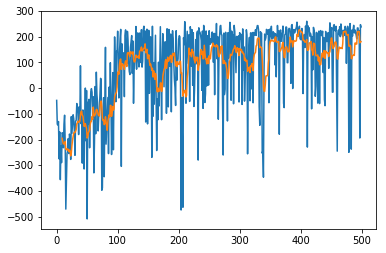

In [183]:
df_train.rewards.plot()
df_train.rewards.rolling(window=10).mean().plot()
plt.xlabel('Episode index')
plt.ylabel('Cumulative reward')

In [ ]:
df_train

In [184]:
df_test.rewards.describe()

count    100.000000
mean     181.390440
std      104.385360
min     -288.577569
25%      176.545216
50%      204.583687
75%      235.180576
max      264.547224
Name: rewards, dtype: float64

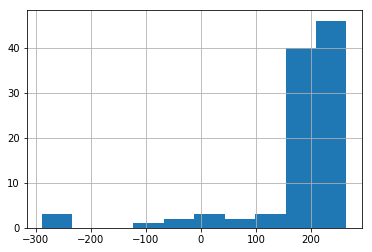

In [185]:
_ = df_test.rewards.hist()

### DDQN

In [189]:
!rm -rf monitor/

In [190]:
env = gym.make('LunarLander-v2')

agent = LunarLander(env,
                    memory_size,
                    target_update_frequency,
                    activation,
                    number_layers,
                    number_hidden_units,
                    learning_rate,
                    epsilon_decay,
                    epsilon_min,
                    sample_size,
                    learning_threshold_samples,
                    gamma,
                    loss_function,
                    buffer_class,
                    monitor_directory,
                    log_folder,
                    log_verbose,
                    is_double_dqn=True,
                    seed=seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 500)               4500      
_________________________________________________________________
activation_22 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 500)               250500    
_________________________________________________________________
activation_23 (Activation)   (None, 500)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 2004      
_________________________________________________________________
activation_24 (Activation)   (None, 4)                 0         
Total params: 257,004
Trainable params: 257

In [191]:
agent.run(episodes)

Episode    1 => reward= -404.5, steps= 102, loss=   0.0
Episode    2 => reward= -206.6, steps=  66, loss=   0.0
Episode    3 => reward= -154.1, steps=  72, loss=   0.0
Episode    4 => reward= -268.8, steps=  75, loss=   0.0
Episode    5 => reward= -172.3, steps=  98, loss=   0.0
Episode    6 => reward= -340.5, steps=  86, loss=   0.0
Episode    7 => reward= -198.7, steps= 109, loss=   0.0
Episode    8 => reward= -115.6, steps= 128, loss=   0.0
Episode    9 => reward= -202.8, steps=  93, loss=   0.0
Episode   10 => reward= -146.8, steps= 109, loss=   0.0
Episode   11 => reward= -199.8, steps=  89, loss= 245.3
Episode   12 => reward= -532.7, steps= 108, loss= 696.1
Episode   13 => reward= -442.8, steps= 125, loss= 418.1
Episode   14 => reward= -110.0, steps=  62, loss= 127.9
Episode   15 => reward= -205.5, steps= 118, loss= 250.9
Episode   16 => reward= -203.3, steps= 110, loss= 245.5
Episode   17 => reward=  -36.4, steps=  93, loss= 227.5
Episode   18 => reward= -318.4, steps=  85, loss

Episode  148 => reward= -114.2, steps= 494, loss= 340.9
Episode  149 => reward=  181.2, steps= 423, loss= 310.4
Episode  150 => reward= -188.8, steps= 220, loss= 152.4
Episode  151 => reward=  124.1, steps= 773, loss= 538.1
Episode  152 => reward=   22.5, steps=1000, loss= 666.9
Episode  153 => reward= -104.6, steps= 690, loss= 477.5
Episode  154 => reward= -176.1, steps= 558, loss= 393.5
Episode  155 => reward=   51.5, steps=1000, loss= 698.5
Episode  156 => reward=  -79.5, steps= 402, loss= 277.8
Episode  157 => reward=  197.0, steps= 459, loss= 307.1
Episode  158 => reward= -155.2, steps= 338, loss= 253.0
Episode  159 => reward=  -88.0, steps=1000, loss= 712.3
Episode  160 => reward=   19.2, steps=1000, loss= 681.0
Episode  161 => reward=  209.5, steps= 567, loss= 414.6
Episode  162 => reward=  175.6, steps= 435, loss= 303.2
Episode  163 => reward=  197.5, steps= 785, loss= 561.7
Episode  164 => reward=    5.5, steps=1000, loss= 667.1
Episode  165 => reward= -109.4, steps= 216, loss

Episode  295 => reward= -402.8, steps= 112, loss=  77.5
Episode  296 => reward= -245.0, steps= 100, loss=  58.9
Episode  297 => reward= -268.6, steps= 105, loss=  67.7
Episode  298 => reward= -166.2, steps=1000, loss= 634.9
Episode  299 => reward= -242.6, steps= 147, loss=  96.5
Episode  300 => reward=  193.0, steps= 542, loss= 359.9
Episode  301 => reward=  151.3, steps= 767, loss= 500.2
Episode  302 => reward= -332.9, steps= 102, loss=  61.3
Episode  303 => reward=  104.9, steps= 451, loss= 304.6
Episode  304 => reward= -247.0, steps= 299, loss= 199.8
Episode  305 => reward=  192.2, steps= 401, loss= 261.8
Episode  306 => reward=  210.4, steps= 724, loss= 461.3
Episode  307 => reward= -136.0, steps= 175, loss= 114.3
Episode  308 => reward= -281.1, steps= 108, loss=  67.6
Episode  309 => reward=   74.0, steps=1000, loss= 640.9
Episode  310 => reward= -226.9, steps= 100, loss=  59.8
Episode  311 => reward= -233.4, steps=  89, loss=  55.3
Episode  312 => reward= -202.7, steps= 111, loss

Episode  442 => reward=  216.9, steps= 331, loss= 219.6
Episode  443 => reward=  199.8, steps= 499, loss= 327.3
Episode  444 => reward= -195.9, steps= 507, loss= 342.3
Episode  445 => reward=  263.4, steps= 368, loss= 252.1
Episode  446 => reward=  -58.0, steps=1000, loss= 660.5
Episode  447 => reward=  233.1, steps= 454, loss= 317.8
Episode  448 => reward= -279.3, steps= 495, loss= 331.0
Episode  449 => reward=  203.0, steps= 430, loss= 312.4
Episode  450 => reward=  245.2, steps= 322, loss= 217.2
Episode  451 => reward=  245.8, steps= 524, loss= 356.4
Episode  452 => reward=  -23.6, steps=1000, loss= 647.6
Episode  453 => reward=  120.0, steps=1000, loss= 651.0
Episode  454 => reward=   85.5, steps=1000, loss= 640.7
Episode  455 => reward=  225.2, steps= 394, loss= 260.0
Episode  456 => reward=  224.5, steps= 370, loss= 254.4
Episode  457 => reward=  209.6, steps= 331, loss= 211.0
Episode  458 => reward=  185.5, steps= 599, loss= 365.9
Episode  459 => reward=  235.3, steps= 320, loss

In [192]:
agent.run(trials, test=True)

Episode    1 => reward=  193.8, steps= 211, loss=   0.0
Episode    2 => reward=  221.7, steps= 335, loss=   0.0
Episode    3 => reward=  211.6, steps= 199, loss=   0.0
Episode    4 => reward=  220.2, steps= 200, loss=   0.0
Episode    5 => reward=  239.7, steps= 215, loss=   0.0
Episode    6 => reward=  163.3, steps= 533, loss=   0.0
Episode    7 => reward=  172.7, steps= 458, loss=   0.0
Episode    8 => reward=  218.0, steps= 200, loss=   0.0
Episode    9 => reward=  217.2, steps= 191, loss=   0.0
Episode   10 => reward= -196.4, steps= 492, loss=   0.0
Episode   11 => reward=  -60.0, steps= 357, loss=   0.0
Episode   12 => reward=  229.6, steps= 206, loss=   0.0
Episode   13 => reward=  198.9, steps= 350, loss=   0.0
Episode   14 => reward=  205.6, steps= 214, loss=   0.0
Episode   15 => reward=  184.1, steps= 258, loss=   0.0
Episode   16 => reward=  207.2, steps= 200, loss=   0.0
Episode   17 => reward=  222.3, steps= 192, loss=   0.0
Episode   18 => reward=   74.5, steps=1000, loss